This notebook is used to test the accuracy of a model trained in the previous notebook

In [1]:
import numpy as np
from sklearn.model_selection import train_test_split
from PIL import Image
from skimage.io import imread
import time
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
from math import radians, degrees, sin, cos, asin, acos, sqrt

In [2]:
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.xception import preprocess_input

from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D,Flatten
from tensorflow.keras.optimizers import Adam
import tensorflow
import torch
from tensorflow import keras

In [3]:
BASE_DIR = 'C:/Users/evan/Documents/Jupyter/GeoGuessr AI V3/'

min_lat = 25.84
max_lat = 49.38
min_lon = -124.67
max_lon = -66.95

n_lats = len(np.unique(np.round(np.arange(min_lat, max_lat, 0.01))))
n_lons = len(np.unique(np.round(np.arange(min_lon, max_lon, 0.01))))

In [11]:
X_filenames = np.load('X.npy')
y_labels = np.load('y_coordinates.npy')

In [12]:
X_train_filenames, X_val_filenames, y_train, y_val = train_test_split(X_filenames, y_labels, test_size=0.05, random_state=69)
print(X_train_filenames.shape, X_val_filenames.shape)

(64134,) (3376,)


In [6]:
#these two large methods (calculate_centroid and calculate_coords_from_prediction) were experiments to see if I could make the guesses more accurate by performing extra calculations on the neural network output
def calculate_centroid(pred, centerPoint, outlierRadius):
    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    
    #centerPoint should be in lat, lon format
    latInd = round(centerPoint[0] - min_lat)
    lonInd = round(centerPoint[1] - min_lon)
    
    lonPred = np.sum((lon * np.transpose(pred.reshape(n_lats, n_lons)))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)]) 
    latPred = np.sum((lat * np.transpose(pred.reshape(n_lats, n_lons)))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)]) 
    
    magnitudeAdjustment = np.sum(np.transpose(pred.reshape(n_lats, n_lons))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)])
    
    lonPred /= magnitudeAdjustment
    latPred /= magnitudeAdjustment
    
    #print(f'Prediction: {latPred}, {lonPred}')
    
    return latPred, lonPred
    
    
def calculate_coords_from_prediction(pred):
    outlierRadius = 5
    
    lat, lon = np.meshgrid(np.linspace(round(min_lat), round(max_lat), n_lats), np.linspace(round(min_lon), round(max_lon), n_lons))
    
    lonCenter = np.sum(lon * np.transpose(pred.reshape(n_lats, n_lons)))
    latCenter = np.sum(lat * np.transpose(pred.reshape(n_lats, n_lons)))
    
    lonInd = round(lonCenter - min_lon)
    latInd = round(latCenter - min_lat)
    
    #If very high confidence in first guess
    if (np.sort(pred)[-1] / np.sort(pred)[-2]) > 5: #if the most confident location has >5x more confidence than next guess
        return calculate_centroid(pred, onehot_to_coord(np.argmax(pred)), 3)
    
    #If very low confidence in center of mass
    if np.sum(np.transpose(pred.reshape(n_lats, n_lons))[max(0, lonInd-outlierRadius):min(n_lons, lonInd+outlierRadius), max(0, latInd-outlierRadius):min(n_lats, latInd+outlierRadius)]) < 0.5:
        return calculate_centroid(pred, onehot_to_coord(np.argmax(pred)), 10)
    
    #For most predictions, calculate centroid of nearest 80% of weight
    for i in range(1, 30):
        if np.sum(np.transpose(pred.reshape(n_lats, n_lons))[max(0, lonInd-i):min(n_lons, lonInd+i), max(0, latInd-i):min(n_lats, latInd+i)]) > 0.5:
            #print(f'Prediction radius: {i}')
            return calculate_centroid(pred, [latCenter, lonCenter], i)
    
    return latCenter, lonCenter

def coord_to_onehot(coord):
    #Coordinate should be in [lat, lon] format
    lat = round(coord[0]) - round(min_lat)
    lon = abs(round(coord[1]) - round(min_lon))
    return (lat * n_lons) + lon

def onehot_to_coord(value):
    lon = value % n_lons
    lat = round((value - lon)/n_lons)
    return [round(lat) + round(min_lat), round(lon) + round(min_lon)]

#Used to calculate the distance between points on a sphere
def great_circle(lon1, lat1, lon2, lat2):
    if lon1 == lon2 and lat1 == lat2:
        return 0
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    return 6371 * (
        acos(sin(lat1) * sin(lat2) + cos(lat1) * cos(lat2) * cos(lon1 - lon2))
    )

#Generator to use batches of data
class My_Custom_Generator(keras.utils.Sequence):
  def __init__(self, image_filenames, labels, batch_size) :
    self.image_filenames = image_filenames
    self.labels = labels
    self.batch_size = batch_size
    
    
  def __len__(self) :
    return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(np.int32)
  
  
  def __getitem__(self, idx) :
    batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
    batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]
    
    return preprocess_input(np.array([
            imread(BASE_DIR + '/training_data/' + str(file_name))
               for file_name in batch_x])), np.array(batch_y)

In [13]:
batch_size = 8

my_training_batch_generator = My_Custom_Generator(X_train_filenames, y_train, batch_size)
my_validation_batch_generator = My_Custom_Generator(X_val_filenames, y_val, batch_size)

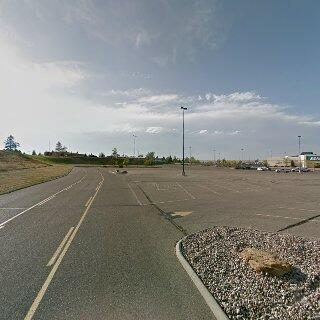

In [8]:
sample_image = imread(f'training_data/{X_train_filenames[7]}')
Image.fromarray(sample_image)

In [9]:
model = keras.models.load_model('Backups/V3_MODEL')

In [30]:
Xv, yv = my_validation_batch_generator.__getitem__(2)

In [39]:
#Categorical Model Test
preds = model.predict(my_validation_batch_generator)
preds_onehot = np.argmax(preds, axis=1)
predCoords = [onehot_to_coord(prediction) for prediction in preds_onehot] 
realCoords = [onehot_to_coord(prediction) for prediction in yv]
dists = [great_circle(predCoords[i][1], predCoords[i][0], realCoords[i][1], realCoords[i][0]) for i in range(len(yv))]
print(f'Model mean distance: {np.mean(dists)}')

Model mean distance: 562.3777870417297


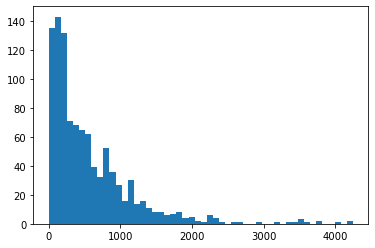

In [40]:
#A histogram of distances between model guess and true location
plt.hist(dists, bins = 50);

Model mean distance: 527.4572437106378


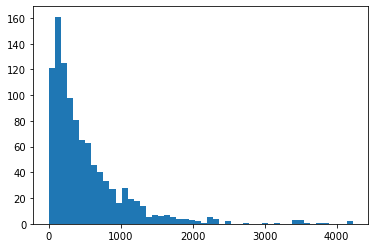

In [46]:
#Alternative guessing method takes into account more of the model output than just maximum square
alt_method_preds = [calculate_coords_from_prediction(pred) for pred in preds]
alt_method_dists = [great_circle(alt_method_preds[i][1], alt_method_preds[i][0], realCoords[i][1], realCoords[i][0]) for i in range(len(yv))]
print(f'Model mean distance: {np.mean(alt_method_dists)}')
plt.hist(alt_method_dists, bins = 50);

Conclusion: with some data massaging, the model can be made slightly more accurate. It is also interesting that averaging guesses makes the distribution of distances more gaussian in shape.